Welcome to Daisyworld! This Notebook is modelled after a program called `daisy.m` written by Dennis Hartmann at the University of Washington. It models the computer simulation described in Watson and Lovelock, 1983, Biological homeostasis of the global environment: [The Parable of Daisyworld](https://www.tandfonline.com/doi/abs/10.3402/tellusb.v35i4.14616), Tellus, 35B,  284-289.

Daisyworld is a computer simulation that looks to show that the [Gaia hypothesis](https://en.wikipedia.org/wiki/Gaia_hypothesis) is plausible. That is, living organisms interact with their environment in a way that regulates and stabilizes that environment, thus perpetuating the conditions needed to support life on a planet. In this simulation, the only two kinds of living organisms are black and white daisies. White daisies have a high albedo and so reflect sunlight, while the black daisies absorb light and heat. We can then track how these two types of daisies compete for resources and affect the surface temeprature of the Earth.

For this program, here are some useful variable explanations:
- `area_w` is the areas covered by white daisies
- `area_b` is the areas covered by black daisies
- `area_g` is the remaining fertile ground not covered by daisies
- `growth_rate_` is the growth rate of the black or white daisies
- `death_rate` is the death rate of the daisies


For this program, recall that emission temperature is calculated as: 

$$T_e = (\frac{S_0 (1 - \alpha)}{\sigma})^\frac{1}{4}$$

Then we can get the emission temperature in degrees Celsius by subtracting ~273K. While calculations must be done in Kelvin, we will plot our output in degrees Celsius.

In [1]:
# do an animated graphic for daisy fraction and temperature (2, 1) plot
# **first for no daisies**, then increase TSI (too cold for life at first, black daisies occur first)
# then go the other direction: the answer should change (too hot for life)

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

While I can't find any evidence that black daisies actually exist, here are what some white and darker-colored daisies might look like:

<tr>
    <td> <img src='daisy_marguerite.jpg' height=1500 width=1500/> </td>
    <td> <img src='osteospermum2.JPG' height=1500 width=1500 /> </td>
</tr>

On the left is is an example of a [Daisy Marguerite](https://en.wikipedia.org/wiki/Argyranthemum), and on the right of an [Osteospermum](https://en.wikipedia.org/wiki/Osteospermum).

### Define Constants

In [31]:
#set variables here
#names for plotting
name_black = 'Black Daisies Only '
name_white = 'White Daisies Only '
name_both = 'Black and White Daisies '
name_neither = 'No Daisies to Start'

#set list to house names
names = [name_black, name_white, name_both, name_neither]

#list/array indexers
i = 0
j = 1

#if change_lumosity is 1, increase lumosity %, if 2 decrease %
change_lumosity = 1

#number of steps to iterate through
steps = 5000

#change in time
delta_t = 0.03

#fractional change in TSI, xaxis on plot
qp = 20.

#Make insolation large, then divide by 4, since you need surfact temperature near 294K
#no GH gases, so S is 3343 W/m^2 to get 20C at one solar constant
s = 3343 
s0 = s / 4

#stefan-boltzmann constant
sigma = 5.67e-8

#death rate of daisies
death_rate = 0.3

#set albedos of daisies here
albedo_b = 0.25
albedo_w = 0.75

#albedo of the dirt or ground
albedo_g = 0.50

#daisy fractions
area_b = [0.2, 0.2, 0]
area_w = [0.2, 0.2, 0]

#initial areas/populations of black and white daisies
area_b_initial = 0.01
area_w_initial = 0.1

#the total fraction of good soil
good_soil = 1.

#how many times to iterate over
iterate = 63
even_odd = 0

### Helper Methods

In [32]:
#pass in a temperature, get out a growth rate
def grow(temp):
    g = 1. - 0.003265 * (22.5 - temp)**2
    grow = max(g, 0.)
    
    return grow

In [33]:
# if black is 1, then set white daisies to 0
# if white is 1, then set black daisies to 0
def zero_area(black, white, area_b, area_w, i, j):
    if black == 0:
        area_b[i] = 0
        area_b[j] = 0
        
    if white == 0:
        area_w[i] = 0
        area_w[j] = 0

In [48]:
#MAIN PROGRAM
def daisyworld(black, white, area_b, area_w, area_b_initial, area_w_initial, albedo_b, albedo_g, albedo_w,
              good_soil, forward, steps, delta_t, death_rate, sigma, s0, qp, change_lumosity, i, j, iterate, even_odd):
    
    #lists to save output to
    xl, ab, aw, tb, tw, te = [], [], [], [], [], []
    
    #set black and white daisy areas to 0 based on variables 'black' and 'white'
    zero_area(black, white, area_b, area_w, i, j)

    #set initial areas for choice of direction
    area_b[i] = area_b_initial
    area_b[j] = area_b_initial

    area_w[i] = area_w_initial
    area_w[j] = area_w_initial
    
    #loop over lumosity either forwards or backwards
    if forward==True:
        #loop from low to high values of lumosity
        lumosity = list(range(0, iterate))
    else:
        #else iterate from high to low values of lumosity
        lumosity = list(range(iterate, 0, -1))
        
    for idx in lumosity:
        if change_lumosity == 1:
            xl_ = 0.5 + (idx) * 0.03
        else:
            xl_ = 2.36 - (idx) * 0.03

        #make sure starting value is not 0 so growth can occur
        area_b[i] = area_b_initial
        area_w[i] = area_w_initial

        #set qu: this is the value Watson and Lovelock used
        qu = 0.2 * s0 * xl_ / sigma

        """
        Once a daisy population gets over half the area, we assume that the starting point is the previous value. 
        Since the system is highly nonlinear, the steady solution obtained depends on the initial value chosen.  
        We imagine that we change the solar constant on an existing population of daisies.
        """
        if area_w[j] > area_w_initial:
            area_w[i] = area_w[j]
            area_b[i] = area_b[j]

        if area_b[j] > area_b_initial:
            area_w[i] = area_w[j]
            area_b[i] = area_b[j]

        #loop over time
        for step in range(steps):
            #set black and white daisy areas to 0 based on variables 'black' and 'white'
            zero_area(black, white, area_b, area_w, i, j)

            #get the area of the ground not covered by daisies
            area_g = good_soil - area_w[i] - area_b[i]

            #now calculate albedo
            albedo = (albedo_g * area_g) + (albedo_w * area_w[i]) + (albedo_b * area_b[i])

            #get all temperatures
            #get global emission temperature
            temp_emit = (s0 * xl_ * (1 - albedo) / sigma)**(1/4) - 273

            #fully non-linear form
            #emission temperature of black daisies
            temp_b = (qu * (albedo - albedo_b) + (temp_emit + 273)**4)**0.25 - 273

            #emission temperature of white daisies
            temp_w = (qu * (albedo - albedo_w) + (temp_emit + 273)**4)**0.25 - 273

            #get growth rate
            growth_rate_b = grow(temp_b)
            growth_rate_w = grow(temp_w)

            #now time step area of daisies
            #2=latest time, j=middle time, i=oldest time
            area_b[j] = area_b[i] + delta_t * (area_b[i] * (area_g * growth_rate_b - death_rate))
            area_w[j] = area_w[i] + delta_t * (area_w[i] * (area_g * growth_rate_w - death_rate))

            #switch i and j indices every other time step
            #reset even_odd variable
            if even_odd == 0:
                i += 1
                j -= 1
                even_odd += 1            
            else:
                i -= 1
                j += 1
                even_odd -= 1
            
            if step > 19:
                diff_daisies = np.abs(area_w[i] - area_w[j]) + np.abs(area_b[i] - area_b[j])

        #append values to output array for plotting
        xl.append(xl_)
        ab.append(area_b[j])
        aw.append(area_w[j])
        tb.append(temp_b)
        tw.append(temp_w)
        te.append(temp_emit)
    
    #save output list for easy indexing and plotting
    output = [xl, aw, ab, tw, tb, te]
    return output

In [49]:
#input the variables 'black', 'white', and list that holds possible plot names
#output the correct title prefix for plotting
def select_title(black, white, names):
    if np.logical_and(black==1, white==0):
        #set title to name_black
        title = names[0]
    elif np.logical_and(black==0, white==1):
        #set title to name_white
        title = names[1]
    elif np.logical_and(black==1, white==1):
        #set title to name_both
        title = names[2]
    else:
        #set title to name_neither
        title = names[3]
        
    return title

In [50]:
#plot TSI agaist both daisy fraction and temperature
def make_plots(black, white, output, albedo_b, albedo_g, albedo_w, change_lumosity, forward, names):

    #make plot interactive
    %matplotlib notebook

    #define figure and axis subplots to plot onto
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    #plot TSI vs black and white daisy area fraction
    ax[0].plot(output[0], output[1], linewidth=1.5, label='Area White')
    ax[0].plot(output[0], output[2], color='r', linewidth=1.5, label='Area Black')
    
    #plot TSI vs temperature: : temp_w, temp_b, temp_emit
    ax[1].plot(output[0], output[3], linewidth=1.5, label='Temp (White)')
    ax[1].plot(output[0], output[4], color='r', linewidth=1.5, label='Temp (Black)')
    ax[1].plot(output[0], output[5], color='gold', linewidth=1.5, label='Emission Temp')
    
    #set xticks
    ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax[0].set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5])
    #do the same thing for axis 1
    ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax[1].set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5])
    
    #label x and y axes
    ax[0].set_xlabel('TSI')
    ax[0].set_ylabel('Daisy Fraction')
    
    ax[1].set_xlabel('TSI')
    ax[1].set_ylabel('Temperature (C)')

    #select correct title here, used for both plots
    title_main = select_title(black, white, names)
    
    #change main title to include forwards or backwards pass over lumosity
    if forward==True:
        title_main += ', forward pass'
    else:
        title_main += ', backward pass'
    
    #main title add-on
    title_to_add = ', albedo_b={}, albedo_g={}, albedo_w={}, change_lumosity={}'.format(albedo_b, albedo_g, albedo_w, change_lumosity)
    
    #set subplot titles here
    ax[0].set_title('Area')
    ax[1].set_title('Temperature')
    
    #add main title here
    plt.suptitle(title_main + title_to_add)

    #add legend to plots
    ax[0].legend()
    ax[1].legend()

    #display plot
    plt.show()

In [149]:
#animate TSI agaist both daisy fraction and temperature
def make_plots_animate(black, white, output, albedo_b, albedo_g, albedo_w, change_lumosity, forward, names):
    
    #make plot interactive
    %matplotlib notebook

    #define figure and axis subplots to plot onto
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    #set axis limits (you have to do this explicitly for animations)
    ax[0].set_xlim(0, 2.5)
    ax[0].set_ylim(0, 1)

    ax[1].set_xlim(0, 2.5)
    ax[1].set_ylim(-30, 100)

    #set xticks
    ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax[0].set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5])

    #do the same thing for axis 1
    ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
    ax[1].set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5])

    #label x and y axes
    ax[0].set_xlabel('TSI')
    ax[0].set_ylabel('Daisy Fraction')

    ax[1].set_xlabel('TSI')
    ax[1].set_ylabel('Temperature (C)')

    #select correct title here, used for both plots
    title_main = select_title(black, white, names)

    #change main title to include forwards or backwards pass over lumosity
    if forward==True:
        title_main += ', forward pass'
    else:
        title_main += ', backward pass'

    #main title add-on
    title_to_add = ', albedo_b={}, albedo_g={}, albedo_w={}, change_lumosity={}'.format(albedo_b, albedo_g, albedo_w, change_lumosity)

    #set subplot titles here
    ax[0].set_title('Area')
    ax[1].set_title('Temperature')

    #add main title here
    plt.suptitle(title_main + title_to_add)

    #plot TSI vs black and white daisy area fraction
    line1, = ax[0].plot([], [], lw=1.5, label='Area White')
    line2, = ax[0].plot([], [], color='r', lw=1.5, label='Area Black')

    #plot TSI vs temperature: : temp_w, temp_b, temp_emit
    line3, = ax[1].plot([], [], lw=1.5, label='Temp (White)')
    line4, = ax[1].plot([], [], color='r', lw=1.5, label='Temp (Black)')
    line5, = ax[1].plot([], [], color='gold', lw=1.5, label='Emission Temp')

    #add legend to plots
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')

    #the animation function wants an init_func variable
    #so we initialize all lines to blank
    def init():
        line.set_data([], [])
        return line1, line2, line3, line4, line5,

    #to animate, iterate over the 'frames' parameter
    def animate(idx):
        #these lines corresponds to the indices of our output array
        #output = [xl, aw, ab, tw, tb, te]
        line1.set_data(output[0][0:idx], output[1][0:idx])
        line2.set_data(output[0][0:idx], output[2][0:idx])
        line3.set_data(output[0][0:idx], output[3][0:idx])
        line4.set_data(output[0][0:idx], output[4][0:idx])
        line5.set_data(output[0][0:idx], output[5][0:idx])

        #return the lines plotted up to a certain index
        return line1, line2, line3, line4, line5,

    #call our animation function
    anim = FuncAnimation(fig, animate, init_func=init, frames=63, interval=200, blit=True)
    
    return anim

Before we run the actual method, we should first talk a little about [hysteresis](https://en.wikipedia.org/wiki/Hysteresis). Simply put, hysteresis is an effect lagging behind a cause in non-linear systems when that system's state is dependent on its history. Let's unpack that a bit.

Hysteresis pops up everywhere in science: physics, biology, atmospheric science. For instance, glacial meltwater from Greenland can affect the salt content (and therefore density profile) in the North Atlantic. This can trigger a shutdown of [AMOC](https://en.wikipedia.org/wiki/Shutdown_of_thermohaline_circulation), or the Atlantic Meridional Overturning Circulation. This has huge implications for heat transport and deep water formation in the Arctic, and this is a function of how much fresh water has built up on the surface of the North Atlantic Ocean. Changes can be quick, and will only change back if enough salt has built back up in the North Atlantic (say from ice sheet formation and growth which would take up more fresh water). There is even evidence that this mechanism caused the [Younger Dryas](https://en.wikipedia.org/wiki/Younger_Dryas), which shows how quick and drastic changes can occur in systems that exhibit hysteresis. Thus, we can say that AMOC exhibits hysteresis in that heat transport and deep water formation (its state) depends on how much freshwater there is at the surface of the North Atlantic (its history).

One thing to keep in mind is that hysteresis is *path dependent*. That is to say, a system will exhibit different behavior and change based on how that system develops. So if we experiment with running lumosity backwards and forwards (increasing or decreasing), then we would expect black and white daisies to evolve in different ways. For instance, if we start at low lumosity, we would expect black daisies to grow first whereas if we start at a high value of lumosity white daisies will be first.

In [155]:
#**TO CHANGE**
#we can change the variables black and white to 0 or 1 here
#if black and white are both 0, then neither exist to start
#if black and white are both 1, then both exist to start
#if forward is True, run lumosity from low to high; if false, reverse that loop
black = 1
white = 1
forward = True

#call main program here
#NOTE: This is for the forward pass (forward in time). 
#We will need to work on something for coding the backwards pass through time.
output = daisyworld(black, white, area_b, area_w, area_b_initial, area_w_initial, albedo_b, albedo_g, albedo_w,
              good_soil, forward, steps, delta_t, death_rate, sigma, s0, qp, change_lumosity, i, j, iterate, even_odd)

<IPython.core.display.Javascript object>


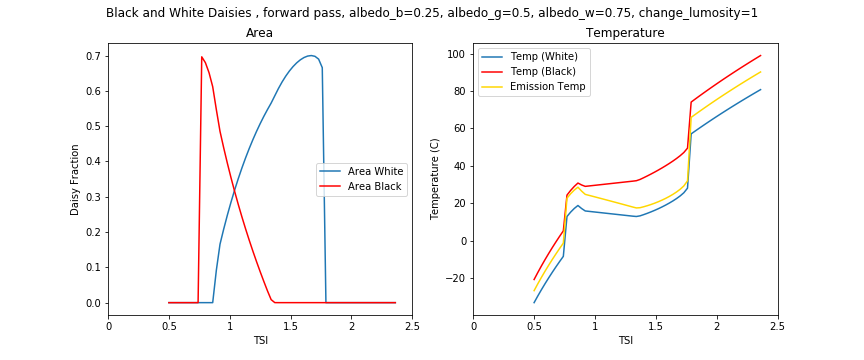

In [157]:
#plot output here
make_plots(black, white, output, albedo_b, albedo_g, albedo_w, change_lumosity, forward, names)

<IPython.core.display.Javascript object>


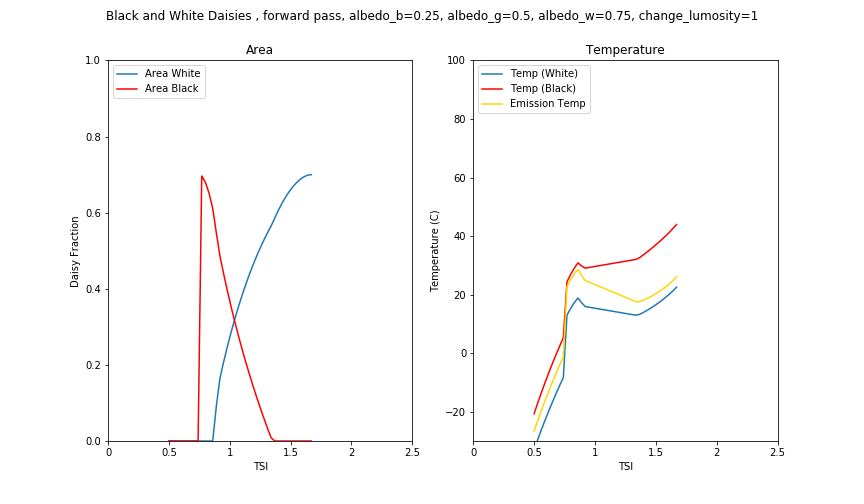

In [160]:
#or animate output here
make_plots_animate(black, white, output, albedo_b, albedo_g, albedo_w, change_lumosity, forward, names)